# **Import library**

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import openpyxl

%matplotlib inline
# plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
import warnings
warnings.simplefilter("ignore")

# ***Data Preparation***

## **CSV Handling**

In [3]:
df = pd.read_excel("../MEC_dataset/training_WeeklyAggregate.xlsx")
df.head()

,sourceid,dstid,dow,mean_travel_time
0,10,241,3,2334.43
1,10,612,5,1529.83
2,10,905,4,1390.04
3,10,407,7,157.91
4,10,603,4,1781.67


In [4]:
pop = pd.read_excel("C:/Users/lowmi/Downloads/Compressed/MEC_dataset/population_density.xlsx")
pop.head()

,la_name,population_density
0,Hillingdon,2671
1,Newham,9808
2,Lambeth,11998
3,Richmond upon Thames,3451
4,Southwark,11091


In [5]:
df.columns

Index(['sourceid', 'dstid', 'dow', 'mean_travel_time'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830 entries, 0 to 9829
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sourceid          9830 non-null   int64  
 1   dstid             9830 non-null   int64  
 2   dow               9830 non-null   int64  
 3   mean_travel_time  9830 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 307.3 KB


In [7]:
df.describe()

,sourceid,dstid,dow,mean_travel_time
count,9830.000000,9830.000000,9830.000000,9830.000000
mean,491.000000,490.849542,4.112818,1621.815974
std,283.781945,285.434568,1.999946,747.806487
min,0.000000,0.000000,1.000000,86.420000
25%,245.000000,248.250000,2.000000,1064.592500
50%,491.000000,479.000000,4.000000,1570.710000
75%,737.000000,750.000000,6.000000,2122.142500
max,982.000000,982.000000,7.000000,4789.000000


In [8]:
df.nunique()

sourceid             983
dstid                980
dow                    7
mean_travel_time    9638
dtype: int64

## **GeoJson Handling**

In [9]:
london = gpd.read_file("C:/Users/lowmi/Downloads/Compressed/MEC_dataset/london.json")

In [10]:
london.head()

,msoa_code,msoa_name,la_code,la_name,geoeast,geonorth,popeast,popnorth,area_km2,MOVEMENT_ID,DISPLAY_NAME,geometry
0,E02000508,Hillingdon 015,00AS,Hillingdon,506163,183536,505978,183811,2.74660,0,"Hillingdon, 00AS (0)","MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51..."
1,E02000716,Newham 003,00BB,Newham,541978,186009,541870,185568,1.56517,1,"Newham, 00BB (1)","MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5..."
2,E02000747,Newham 034,00BB,Newham,539578,181317,539891,181438,2.08241,2,"Newham, 00BB (2)","MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5..."
3,E02000748,Newham 035,00BB,Newham,542500,181152,542439,181339,1.33175,3,"Newham, 00BB (3)","MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5..."
4,E02000749,Newham 036,00BB,Newham,541047,181103,540847,181294,1.41902,4,"Newham, 00BB (4)","MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5..."


In [11]:
london.nunique()

msoa_code       983
msoa_name       983
la_code          33
la_name          33
geoeast         970
geonorth        971
popeast         974
popnorth        970
area_km2        982
MOVEMENT_ID     983
DISPLAY_NAME    983
geometry        983
dtype: int64

In [12]:
london.crs
#"EPSG: 27700" Projected

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   msoa_code     983 non-null    object  
 1   msoa_name     983 non-null    object  
 2   la_code       983 non-null    object  
 3   la_name       983 non-null    object  
 4   geoeast       983 non-null    int64   
 5   geonorth      983 non-null    int64   
 6   popeast       983 non-null    int64   
 7   popnorth      983 non-null    int64   
 8   area_km2      983 non-null    float64 
 9   MOVEMENT_ID   983 non-null    object  
 10  DISPLAY_NAME  983 non-null    object  
 11  geometry      983 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(6)
memory usage: 92.3+ KB


In [14]:
london["MOVEMENT_ID"] = london["MOVEMENT_ID"].astype("int64")
london["x"] = london.centroid.x
london["y"] = london.centroid.y

In [15]:
london.head()

,msoa_code,msoa_name,la_code,la_name,geoeast,geonorth,popeast,popnorth,area_km2,MOVEMENT_ID,DISPLAY_NAME,geometry,x,y
0,E02000508,Hillingdon 015,00AS,Hillingdon,506163,183536,505978,183811,2.74660,0,"Hillingdon, 00AS (0)","MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51...",-0.470593,51.540762
1,E02000716,Newham 003,00BB,Newham,541978,186009,541870,185568,1.56517,1,"Newham, 00BB (1)","MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5...",0.046567,51.555122
2,E02000747,Newham 034,00BB,Newham,539578,181317,539891,181438,2.08241,2,"Newham, 00BB (2)","MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5...",0.010071,51.513538
3,E02000748,Newham 035,00BB,Newham,542500,181152,542439,181339,1.33175,3,"Newham, 00BB (3)","MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5...",0.052078,51.511347
4,E02000749,Newham 036,00BB,Newham,541047,181103,540847,181294,1.41902,4,"Newham, 00BB (4)","MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5...",0.031180,51.511230


In [16]:
# plt.figure(figsize=(40,40),dpi=)
# ax = london.plot()
# london.apply(lambda x: ax.annotate(text=x.MOVEMENT_ID, xy=x.geometry.centroid.coords[0], ha="center"), axis=1)
# plt.show()

In [17]:
ldn = london.to_crs("EPSG: 27700")
#"EPSG: 27700"

<AxesSubplot:>

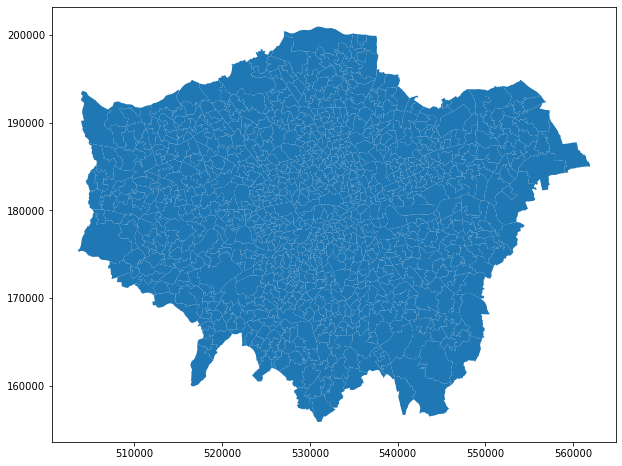

In [18]:
ldn.plot()

# ***OpenStreetMap (OSMnx) Initialization***

https://osmnx.readthedocs.io/en/stable/index.html

## Load saved geopackage

In [19]:
# fp = "https://github.com/mystique1011/ML_competition/blob/main/MEC_dataset/london.gpkg?raw=true"
# gdf_nodes = gpd.read_file(fp, layer="nodes").set_index("osmid")
# gdf_edges = gpd.read_file(fp, layer="edges").set_index(["u", "v", "key"])
# assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

# # convert the node/edge GeoDataFrames to a MultiDiGraph
# graph_attrs = {"crs": "epsg:4326", "simplified": False}
# G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

## Download nodes from OpenStreetMap

In [20]:
G = ox.graph_from_place("London, England", network_type = "drive")

# fig, ax = ox.plot_graph(G)

In [21]:
# ox.io.save_graph_geopackage(G,"../MEC_dataset/london.gpkg")

In [22]:
# edge_centrality = nx.closeness_centrality(nx.line_graph(G))
# nx.set_edge_attributes(G, edge_centrality, "edge_centrality")
# ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
# fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Important OSMNx Function

In [23]:
G = ox.utils_graph.remove_isolated_nodes(G)
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [24]:
def get_route(dataframe,attr="nodes", weight="length", cpus=1):
    if attr=="nodes":
        rt = ox.shortest_path(G,dataframe["node_id_n_src"],dataframe["node_id_n_dst"], weight=weight,cpus=cpus)
    else:
        rt = ox.shortest_path(G,dataframe["node_id_e_src"],dataframe["node_id_e_dst"], weight=weight,cpus=cpus)
    return rt

In [25]:
def get_attr(route, feature=None):
    return ox.utils_graph.get_route_edge_attributes(G,route,feature)

In [26]:
def get_attr_count(route, attribute):
    attribute_values = []
    for u, v in zip(route[:-1], route[1:]):
        data = min(G.get_edge_data(u, v).values(), key=lambda x: x["length"])
        try:
            attribute_value = data[attribute]
            attribute_values.append(attribute_value)
        except KeyError:
            pass
    return attribute_values

## Extract

In [27]:
# Get osmid from London.json
london["node_id_n"] = ox.distance.nearest_nodes(G,london.centroid.x,london.centroid.y)
london[["node_id_e","nodes_id_2","to_drop"]] = ox.distance.nearest_edges(G,london.centroid.x,london.centroid.y)

# ***Feature Extraction***

## **Get important features from geospatial data**

In [28]:
pop.head()

,la_name,population_density
0,Hillingdon,2671
1,Newham,9808
2,Lambeth,11998
3,Richmond upon Thames,3451
4,Southwark,11091


In [29]:
london = london.merge(pop,left_on = "la_name", right_on = "la_name", how = "left")

In [30]:
london.head()

,msoa_code,msoa_name,la_code,la_name,geoeast,geonorth,popeast,popnorth,area_km2,MOVEMENT_ID,DISPLAY_NAME,geometry,x,y,node_id_n,node_id_e,nodes_id_2,to_drop,population_density
0,E02000508,Hillingdon 015,00AS,Hillingdon,506163,183536,505978,183811,2.74660,0,"Hillingdon, 00AS (0)","MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51...",-0.470593,51.540762,6271776012,6307891023,7857342724,0,2671
1,E02000716,Newham 003,00BB,Newham,541978,186009,541870,185568,1.56517,1,"Newham, 00BB (1)","MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5...",0.046567,51.555122,6331732604,32636604,32636592,0,9808
2,E02000747,Newham 034,00BB,Newham,539578,181317,539891,181438,2.08241,2,"Newham, 00BB (2)","MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5...",0.010071,51.513538,662105375,662105375,662105365,0,9808
3,E02000748,Newham 035,00BB,Newham,542500,181152,542439,181339,1.33175,3,"Newham, 00BB (3)","MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5...",0.052078,51.511347,666992158,667024057,526010386,0,9808
4,E02000749,Newham 036,00BB,Newham,541047,181103,540847,181294,1.41902,4,"Newham, 00BB (4)","MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5...",0.031180,51.511230,282590709,135551775,283249668,0,9808


In [31]:
ldn = london.drop(["DISPLAY_NAME","geometry","msoa_code","msoa_name","la_code","nodes_id_2","to_drop"],axis=1)

src = df.merge(ldn, left_on = "sourceid", right_on = "MOVEMENT_ID", how = "left")
src = src.rename({"geoeast":"geoeast_src", "geonorth":"geonorth_src","popeast":"popeast_src","popnorth":"popnorth_src",
                  "la_name":"la_name_src","area_km2":"area_src", "msoa_code":"msoa_code_src", "x" : "src_x", "y" : "src_y",
                 "node_id_n" : "node_id_n_src", "node_id_e" : "node_id_e_src","population_density":"population_density_src"},axis = 1)

dst = src.merge(ldn, left_on = "dstid", right_on = "MOVEMENT_ID", how = "left")
dst = dst.rename({"geoeast":"geoeast_dst", "geonorth":"geonorth_dst","popeast":"popeast_dst","popnorth":"popnorth_dst",
                  "la_name":"la_name_dst","area_km2":"area_dst","msoa_code":"msoa_code_dst","x" : "dst_x", "y" : "dst_y",
                  "node_id_n" : "node_id_n_dst", "node_id_e" : "node_id_e_dst","population_density":"population_density_dst"},axis = 1)

df = dst.drop(["MOVEMENT_ID_x","MOVEMENT_ID_y"],axis=1)

df.head()

,sourceid,dstid,dow,mean_travel_time,la_name_src,geoeast_src,geonorth_src,popeast_src,popnorth_src,area_src,...,geoeast_dst,geonorth_dst,popeast_dst,popnorth_dst,area_dst,dst_x,dst_y,node_id_n_dst,node_id_e_dst,population_density_dst
0,10,241,3,2334.43,Newham,542413,182380,542450,182415,0.790802,...,530851,174285,530876,174289,0.584104,-0.118199,51.452418,33776678,33776696,11998
1,10,612,5,1529.83,Newham,542413,182380,542450,182415,0.790802,...,551347,192721,550534,191931,6.279430,0.184471,51.612990,1138048373,25760609,2320
2,10,905,4,1390.04,Newham,542413,182380,542450,182415,0.790802,...,535060,178641,535009,178663,0.662274,-0.056014,51.490606,104397683,270932211,11091
3,10,407,7,157.91,Newham,542413,182380,542450,182415,0.790802,...,544366,183515,544543,183531,0.796626,0.079911,51.532079,180624488,180624488,5933
4,10,603,4,1781.67,Newham,542413,182380,542450,182415,0.790802,...,532416,197315,532432,197391,1.282990,-0.087059,51.659039,11377862,11379331,4127


## **Calculate Displacement**

In [32]:
df["geo_displacement"] = np.linalg.norm(df.loc[:, ["geoeast_src","geonorth_src"]].values - df.loc[:, ["geoeast_dst","geonorth_dst"]], axis=1)
df["pop_displacement"] = np.linalg.norm(df.loc[:, ["popeast_src","popnorth_src"]].values - df.loc[:, ["popeast_dst","popnorth_dst"]], axis=1)

In [33]:
df["geo_displacement_log"] = np.log(df["geo_displacement"].values + 1)
df["geo_displacement_sqrt"] =  np.sqrt(df["geo_displacement"])

## **Calculate Direction**

In [34]:
xDiff = df.loc[:, "geonorth_dst"].values - df.loc[:, "geonorth_src"].values
yDiff = df.loc[:, "geoeast_dst"].values - df.loc[:, "geoeast_src"].values
df["direction"] = np.round(np.degrees(np.arctan2(yDiff,xDiff)))

# **OSMnx features**

In [40]:
df["route_travel_time"] = get_route(df,weight="travel_time")

In [41]:
missing_route_travel_time = df[df["route_travel_time"].isna()]
len(missing_route_travel_time)

32

## Missing route handling

In [42]:
df.loc[missing_route_travel_time.index,"route_travel_time"] = get_route(missing_route_travel_time,"edges","travel_time")

In [43]:
missing_route_travel_time = df[df["route_travel_time"].isna()]
len(missing_route_travel_time)

0

## Extract Features

In [47]:
df["road_distance_by_travel_time"] = [round(sum(get_attr(row["route_travel_time"], "length"))) for index, row in df.iterrows()]
df["maxspeed_travel_time"] = [round(np.mean(get_attr(row["route_travel_time"], "speed_kph"))) for index, row in df.iterrows()]
df["fastest_travel_time"] = [round(sum(get_attr(row["route_travel_time"], "travel_time"))) for index, row in df.iterrows()]

In [48]:
oneway_len=[]
for index, row in df.iterrows():
    oneway = get_attr(row["route_travel_time"], "oneway")
    length = get_attr(row["route_travel_time"], "length")
    one_len = np.array(length)[np.array(oneway)]
    oneway_len.append(round(np.sum(one_len)))
    
df["oneway_length_by_travel_time"] = oneway_len

# ***Categorical to Numerical***

In [49]:
ordinal_encoder = OrdinalEncoder()
object_cols = ["la_name_src","la_name_dst"]
df[["la_name_src_num","la_name_dst_num"]] = ordinal_encoder.fit_transform(df[object_cols])

In [50]:
df.head(3)

,sourceid,dstid,dow,mean_travel_time,la_name_src,geoeast_src,geonorth_src,popeast_src,popnorth_src,area_src,...,geo_displacement_sqrt,direction,route_travel_time,road_distance_by_travel_time,maxspeed_length,maxspeed_travel_time,fastest_travel_time,oneway_length_by_travel_time,la_name_src_num,la_name_dst_num
0,10,241,3,2334.43,Newham,542413,182380,542450,182415,0.790802,...,118.802934,-125.0,"[5670849155, 5670849154, 21643445, 3639591391,...",19291,48,48,1413,9096,24.0,21.0
1,10,612,5,1529.83,Newham,542413,182380,542450,182415,0.790802,...,116.900585,41.0,"[5670849155, 5670849154, 21643445, 3639591391,...",17966,55,55,1084,12250,24.0,15.0
2,10,905,4,1390.04,Newham,542413,182380,542450,182415,0.790802,...,90.824249,-117.0,"[5670849155, 5670849154, 21643445, 3639591391,...",11622,49,49,899,6326,24.0,27.0


# Solving for testing dataset

In [74]:
test = pd.read_csv("C:/Users/lowmi/Downloads/Compressed/MEC_dataset/testing_dataset.csv",index_col=0)

In [75]:
test.head()

,dstid,dow
sourceid,,
10,950,2
10,889,2
260,145,2
260,932,7
41,808,2


In [76]:
ldn = london.drop(["DISPLAY_NAME","geometry","msoa_code","msoa_name","la_code","nodes_id_2","to_drop"],axis=1)

tsrc = test.merge(ldn, left_on = "sourceid", right_on = "MOVEMENT_ID", how = "left")
tsrc = tsrc.rename({"geoeast":"geoeast_src", "geonorth":"geonorth_src","popeast":"popeast_src","popnorth":"popnorth_src",
                  "la_name":"la_name_src","area_km2":"area_src", "msoa_code":"msoa_code_src", "x" : "src_x", "y" : "src_y",
                 "node_id_n" : "node_id_n_src", "node_id_e" : "node_id_e_src"},axis = 1)

tdst = tsrc.merge(ldn, left_on = "dstid", right_on = "MOVEMENT_ID", how = "left")
tdst = tdst.rename({"geoeast":"geoeast_dst", "geonorth":"geonorth_dst","popeast":"popeast_dst","popnorth":"popnorth_dst",
                  "la_name":"la_name_dst","area_km2":"area_dst","msoa_code":"msoa_code_dst","x" : "dst_x", "y" : "dst_y",
                  "node_id_n" : "node_id_n_dst", "node_id_e" : "node_id_e_dst"},axis = 1)

test = tdst.drop(["MOVEMENT_ID_x","MOVEMENT_ID_y"],axis=1)

In [77]:
test["geo_displacement"] = np.linalg.norm(test.loc[:, ["geoeast_src","geonorth_src"]].values - test.loc[:, ["geoeast_dst","geonorth_dst"]], axis=1)
test["pop_displacement"] = np.linalg.norm(test.loc[:, ["popeast_src","popnorth_src"]].values - test.loc[:, ["popeast_dst","popnorth_dst"]], axis=1)

In [78]:
test["geo_displacement_log"] = np.log(test["geo_displacement"].values + 1)
test["geo_displacement_sqrt"] =  np.sqrt(test["geo_displacement"])

In [79]:
xDiff = test.loc[:, "geonorth_dst"].values - test.loc[:, "geonorth_src"].values
yDiff = test.loc[:, "geoeast_dst"].values - test.loc[:, "geoeast_src"].values
test["direction"] = np.round(np.degrees(np.arctan2(yDiff,xDiff)))

In [80]:
test["route_travel_time"] = get_route(test,weight="travel_time")

In [81]:
tmissing_route = test[test["route_travel_time"].isna()]
len(tmissing_route)

5

In [82]:
test.loc[tmissing_route.index,"route_travel_time"] = get_route(tmissing_route,"edges","travel_time")

In [83]:
tmissing_route = test[test["route_travel_time"].isna()]
len(tmissing_route)

0

In [84]:
test["road_distance_by_travel_time"] = [round(sum(get_attr(row["route_travel_time"], "length"))) for index, row in test.iterrows()]
test["maxspeed_travel_time"] = [round(np.mean(get_attr(row["route_travel_time"], "speed_kph"))) for index, row in test.iterrows()]
test["fastest_travel_time"] = [round(sum(get_attr(row["route_travel_time"], "travel_time"))) for index, row in test.iterrows()]

In [85]:
oneway_len_travel_time=[]
for index, row in test.iterrows():
    oneway = get_attr(row["route_travel_time"], "oneway")
    length = get_attr(row["route_travel_time"], "length")
    one_len = np.array(length)[np.array(oneway)]
    oneway_len_travel_time.append(round(np.sum(one_len)))
    
test["oneway_length_by_travel_time"] = oneway_len_travel_time

In [86]:
test.head()

,dstid,dow,la_name_src,geoeast_src,geonorth_src,popeast_src,popnorth_src,area_src,src_x,src_y,...,geo_displacement,pop_displacement,geo_displacement_log,geo_displacement_sqrt,direction,route_travel_time,road_distance_by_travel_time,maxspeed_travel_time,fastest_travel_time,oneway_length_by_travel_time
0,950,2,Newham,542413,182380,542450,182415,0.790802,0.051341,51.522387,...,9987.337683,10035.206276,9.209173,99.936668,-20.0,"[5670849155, 5670849154, 21643445, 3639591391,...",14058,54,779,11575
1,889,2,Newham,542413,182380,542450,182415,0.790802,0.051341,51.522387,...,3066.908052,2790.788419,8.028751,55.379672,-85.0,"[5670849155, 21643453, 21643501, 21643502, 216...",4045,42,353,192
2,145,2,Lewisham,537348,173695,537370,173721,1.159180,-0.025001,51.445594,...,6489.098088,6544.474463,8.778033,80.554938,101.0,"[650196, 629137, 432851, 650110, 7197704265, 6...",8546,52,586,4897
3,932,7,Lewisham,537348,173695,537370,173721,1.159180,-0.025001,51.445594,...,7976.137536,7908.896510,8.984335,89.309224,7.0,"[650196, 629137, 432851, 650110, 7197704265, 6...",13153,52,858,9399
4,808,2,Barking and Dagenham,549480,182645,549514,183612,3.296880,0.153237,51.522967,...,9116.951080,8935.664777,9.118000,95.482727,-76.0,"[195822273, 6443477788, 195817780, 195819205, ...",12521,51,860,6178
